In [1]:
import os
from typing import TypedDict, Annotated, Sequence, List
from langgraph.graph import Graph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from openai import OpenAI
from PIL import Image
import io
from IPython.display import display, Image as IPImage

from langchain_core.runnables.graph import MermaidDrawMethod

import asyncio
import aiohttp
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Initialize OpenAI client
client = OpenAI()

In [2]:
class GraphState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage], "The messages in the conversation"]
    query: Annotated[str, "Input query describing the character and scene"]
    plot: Annotated[str, "Generated plot for the GIF"]
    character_description: Annotated[str, "Detailed description of the main character or object"]
    image_prompts: Annotated[List[str], "List of prompts for each frame"]
    image_urls: Annotated[List[str], "List of URLs for generated images"]
    gif_data: Annotated[bytes, "GIF data in bytes"]

# Initialize the language model
llm = ChatOpenAI(model="gpt-4")

In [3]:
async def get_image_data(session, url: str):
    """Fetch image data from a given URL."""
    async with session.get(url) as response:
        if response.status == 200:
            return await response.read()
    return None

def generate_character_description(state: GraphState) -> GraphState:
    """Generate a detailed description of the main character or scene."""
    query = state["query"]
    response = llm.invoke([HumanMessage(content=f"Based on the query '{query}', create a detailed description of the main character, object, or scene. Include specific details about appearance, characteristics, and any unique features. This description will be used to maintain consistency across multiple images.")])
    state["character_description"] = response.content
    return state

def generate_plot(state: GraphState) -> GraphState:
    """Generate a 5-step plot for the GIF animation."""
    query = state["query"]
    character_description = state["character_description"]
    response = llm.invoke([HumanMessage(content=f"Create a short, 5-step plot for a GIF based on this query: '{query}' and featuring this description: {character_description}. Each step should be a brief description of a single frame, maintaining consistency throughout. Keep it family-friendly and avoid any sensitive themes.")])
    state["plot"] = response.content
    return state

def generate_image_prompts(state: GraphState) -> GraphState:
    """Generate specific image prompts for each frame of the GIF."""
    plot = state["plot"]
    character_description = state["character_description"]
    response = llm.invoke([HumanMessage(content=f"""Based on this plot: '{plot}' and featuring this description: {character_description}, generate 5 specific, family-friendly image prompts, one for each step. Each prompt should be detailed enough for image generation, maintaining consistency, and suitable for DALL-E. 

Always include the following in EVERY prompt to maintain consistency:
1. A brief reminder of the main character or object's key features
2. The specific action or scene described in the plot step
3. Any relevant background or environmental details

Format each prompt as a numbered list item, like this:
1. [Your prompt here]
2. [Your prompt here]
... and so on.""")])
    
    prompts = []
    for line in response.content.split('\n'):
        if line.strip().startswith(('1.', '2.', '3.', '4.', '5.')):
            prompt = line.split('.', 1)[1].strip()
            prompts.append(f"Create a detailed, photorealistic image of the following scene: {prompt}")
    
    if len(prompts) != 5:
        raise ValueError(f"Expected 5 prompts, but got {len(prompts)}. Please try again.")
    
    state["image_prompts"] = prompts
    return state

async def create_image(prompt: str, retries: int = 3):
    """Generate an image using DALL-E based on the given prompt."""
    for attempt in range(retries):
        try:
            response = await asyncio.to_thread(
                client.images.generate,
                model="dall-e-3",
                prompt=prompt,
                size="1024x1024",
                quality="standard",
                n=1,
            )
            return response.data[0].url
        except Exception as e:
            if attempt == retries - 1:
                print(f"Failed to generate image for prompt: {prompt}")
                print(f"Error: {str(e)}")
                return None
            await asyncio.sleep(2)  # Wait before retrying

async def create_images(state: GraphState) -> GraphState:
    """Generate images for all prompts in parallel."""
    image_prompts = state["image_prompts"]
    tasks = [create_image(prompt) for prompt in image_prompts]
    image_urls = await asyncio.gather(*tasks)
    state["image_urls"] = image_urls
    return state

async def create_gif(state: GraphState) -> GraphState:
    """Create a GIF from the generated images."""
    image_urls = state["image_urls"]
    images = []
    async with aiohttp.ClientSession() as session:
        tasks = [get_image_data(session, url) for url in image_urls if url]
        image_data_list = await asyncio.gather(*tasks)
    
    for img_data in image_data_list:
        if img_data:
            images.append(Image.open(io.BytesIO(img_data)))
    
    if images:
        gif_buffer = io.BytesIO()
        images[0].save(gif_buffer, format='GIF', save_all=True, append_images=images[1:], duration=1000, loop=0)
        state["gif_data"] = gif_buffer.getvalue()
    else:
        state["gif_data"] = None
    return state

In [4]:
workflow = Graph()

workflow.add_node("generate_character_description", generate_character_description)
workflow.add_node("generate_plot", generate_plot)
workflow.add_node("generate_image_prompts", generate_image_prompts)
workflow.add_node("create_images", create_images)
workflow.add_node("create_gif", create_gif)

workflow.add_edge("generate_character_description", "generate_plot")
workflow.add_edge("generate_plot", "generate_image_prompts")
workflow.add_edge("generate_image_prompts", "create_images")
workflow.add_edge("create_images", "create_gif")
workflow.add_edge("create_gif", END)

workflow.set_entry_point("generate_character_description")

app = workflow.compile()

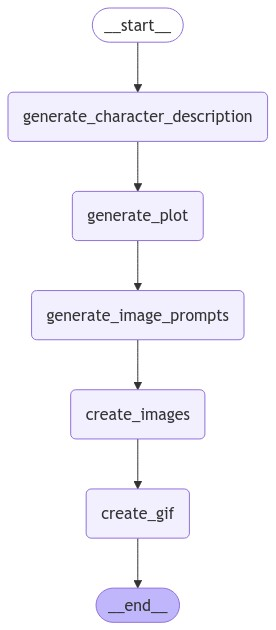

In [5]:
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
async def run_workflow(query: str):
    """Run the LangGraph workflow and display results."""
    initial_state = {
        "messages": [],
        "query": query,
        "plot": "",
        "character_description": "",
        "image_prompts": [],
        "image_urls": [],
        "gif_data": None
    }

    try:
        result = await app.ainvoke(initial_state)

        print("Character/Scene Description:")
        print(result["character_description"])

        print("\nGenerated Plot:")
        print(result["plot"])

        print("\nImage Prompts:")
        for i, prompt in enumerate(result["image_prompts"], 1):
            print(f"{i}. {prompt}")

        print("\nGenerated Image URLs:")
        for i, url in enumerate(result["image_urls"], 1):
            print(f"{i}. {url}")

        if result["gif_data"]:
            print("\nGIF generated successfully. Use the next cell to display or save it.")
        else:
            print("\nFailed to generate GIF.")
        
        return result
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [7]:
query = "A cat wearing a top hat and monocle, sitting at a desk and writing a letter with a quill pen."
result = await run_workflow(query)

Character/Scene Description:
Main Character: The main character is a sophisticated and distinguished cat. This feline is of an average size, with a well-groomed coat of dense, lustrous fur in a hue of rich sable black. Its eyes are emerald green, shimmering with intelligence and curiosity. The cat possesses a long, sweeping tail and delicate paws, which are surprisingly adept at handling the quill pen. Upon its head, the cat sports a luxurious top hat, made of plush black velvet with a satin ribbon band. Over one eye, it wears a polished silver monocle, which is secured by a thin, black ribbon that loops over one ear.

Scene: The scene is set in a cozy study, filled with the soft, ambient glow of candlelight. The cat is perched on a high-backed, leather chair, comfortably settled on plush velvet cushioning. It's sitting upright, demonstrating an almost human-like posture and poise. Its tail is curled neatly around its paws, contributing to the image of genteel refinement.

Desk: The de

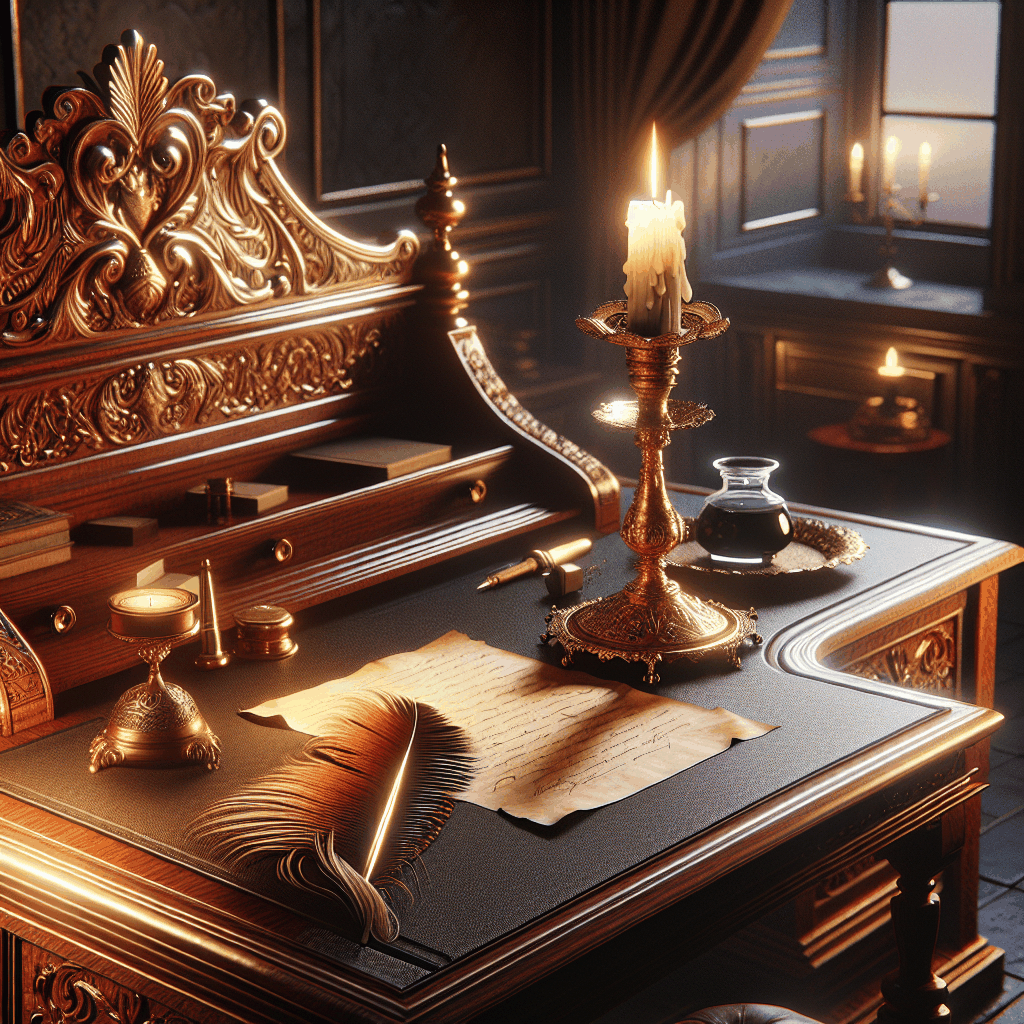

GIF saved as cat_gif.gif


In [8]:
if result and result["gif_data"]:
    # Display the GIF
    display(IPImage(data=result["gif_data"], format='gif'))
    
    # Ask if the user wants to save the GIF
    save_gif = input("Do you want to save the GIF? (yes/no): ").lower().strip()
    if save_gif == 'yes':
        filename = input("Enter the filename to save the GIF (e.g., output.gif): ").strip()
        if not filename.endswith('.gif'):
            filename += '.gif'
        with open(filename, 'wb') as f:
            f.write(result["gif_data"])
        print(f"GIF saved as {filename}")
    else:
        print("GIF not saved.")
else:
    print("No GIF data available to display or save.")